# Set up environment

In [28]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from __future__ import absolute_import
from __future__ import with_statement
from __future__ import division
from __future__ import nested_scopes
from __future__ import generators
from __future__ import unicode_literals
from __future__ import print_function

# Load scipy/numpy/matplotlib
from   scipy.linalg import expm
import matplotlib.pyplot as plt
from   pylab import *
import numpy as np
import scipy.io
from   warnings import warn

# Configure figure resolution
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.rcParams['savefig.dpi'   ] = 100

from izh       import * # Routines for sampling Izhikevich neurons
from plot      import * # Misc. plotting routines
from glm       import * # GLM fitting
from arppglm   import * # Sampling and integration
from utilities import * # Other utilities
from arguments import * # Argument verification

import os
dtype='float32'
os.environ['MKL_THREADING_LAYER']='GNU'
flags = 'mode=FAST_COMPILE,device=cuda0,'#,floatX=%s'%dtype
os.environ["THEANO_FLAGS"] = flags

import theano
import theano.tensor as T

from theano_arppglm import *

print('Workspace Initialized')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Workspace Initialized


# Load saved GLM features

In [29]:
#filename = 'saved_training_model.mat'
filename = 'saved_training_model_badburster.mat'

saved_training_model = scipy.io.loadmat(filename)
K  = np.array(saved_training_model['K'],dtype=dtype)
B  = np.array(saved_training_model['B'],dtype=dtype)
By = np.array(saved_training_model['By'],dtype=dtype)
Bh = np.array(saved_training_model['Bh'],dtype=dtype)
A  = np.array(saved_training_model['A'],dtype=dtype)
C  = np.array(saved_training_model['C'],dtype=dtype)
Y  = np.array(saved_training_model['Y'],dtype=dtype)
dt = np.array(saved_training_model['dt'],dtype=dtype)

Bh_train = saved_training_model['Bh_train']
By_train = saved_training_model['By_train']
X_train  = concatenate([By_train,Bh_train],axis=1)
Y_train  = asvector(saved_training_model['Y_train'])

Bh_test  = saved_training_model['Bh_test']
By_test  = saved_training_model['By_test']
X_test   = concatenate([By_test,Bh_test],axis=1)
Y_test   = asvector(saved_training_model['Y_test'])
 
K  = int(scalar(K))
N  = prod(Y.shape)

N = len(X_train)
STARTPLOT=0
NPLOT=N

print('Saved GLM features loaded')
print(N)

#STARTSHOW = 14000
#STOPSHOW = 16000
STARTSHOW = 0
STOPSHOW = N

Saved GLM features loaded
400


### GLM helpers

In [30]:
def lograte(Bh,By,p):
    '''
    Log-intensity of point process model on this dataset
    Predicted using the standard GLM way
    '''
    m       = array(p).ravel()[0]
    beta    = ascolumn(p[1:K+1])
    beta_st = ascolumn(p[1+K:])
    lograte = m + Bh.dot(beta_st) + By.dot(beta)
    return lograte

def logmean(Bh,M1,p):
    '''
    Projected history process
    Predicted using history-process means
    '''
    m       = array(p).ravel()[0]
    beta    = ascolumn(p[1:K+1])
    beta_st = ascolumn(p[1+K:])
    M1      = np.squeeze(M1)
    return (beta.T.dot(M1.T))[0] + (m + Bh.dot(beta_st))[:,0]

def get_stim(Bh,p):
    m        = array(p).ravel()[0]
    beta     = ascolumn(p[1:K+1])
    beta_st  = ascolumn(p[1+K:])
    stim     = (m + Bh.dot(beta_st))[:,0]
    return stim

def filter_GLM_np(Bh,p):
    m        = array(p).ravel()[0]
    beta     = ascolumn(p[1:K+1])
    beta_st  = ascolumn(p[1+K:])
    stim     = get_stim(Bh,p)
    allM1_np = np.zeros((N,K))
    M1       = np.zeros((K,1))
    for i in range(N):
        R   = scalar(sexp(p0[1:K+1].dot(M1)+m+stim[i]))
        M1 += A.dot(M1)*dt + C.dot(R)
        allM1_np[i] = M1[:,0]
    return allM1_np

def addspikes_(Y_=None):
    if Y_ is None or Y_ is True:
        Y_ = Y
    for t in find(Y_>0):
        axvline(t,color=OCHRE,lw=0.4)
    
def niceaxis(plotspikes=True):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore",message='No labelled objects found')
        legend()
    simpleraxis()
    xlim(STARTSHOW,STOPSHOW)
    if plotspikes is True or not plotspikes is None:
        addspikes_(plotspikes)

print('GLM helpers done')

GLM helpers done


(array([-22.03492371]), 5)

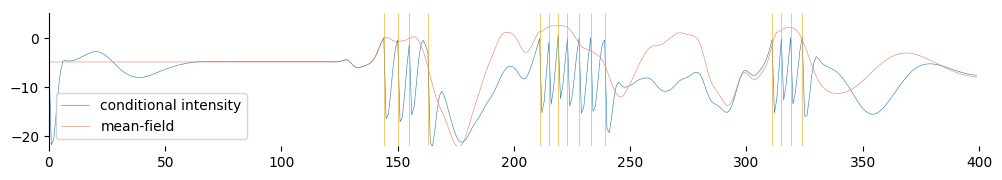

In [31]:
# Re-fit GLM
m,bhat  = fitGLM(X_train,asvector(Y_train))

# Re-pack model parameters
p0      = np.zeros((1+len(bhat)))
p0[0 ]  = m
p0[1:]  = bhat

allM1_np = filter_GLM_np(Bh_train,p0)
subplot(311)
plot(lograte(Bh_train,By_train,p0),lw=0.4,label='conditional intensity')
plot(logmean(Bh_train,allM1_np,p0),lw=0.4,label='mean-field',color=RUST)
niceaxis()
ylim(min(lograte(Bh_train,By_train,p0)),5)

# Filtering 

### Parameters at which to filter

In [32]:
oversample = 10   # Integration resolution
maxrate    = 10.0 # Largest allowed rate
maxvcorr   = 10.0 # Largest allowed variance correction
dt         = 1.0  # Data time resolution
reg_cov    = 1e-5
reg_rate   = 1e-5

p = p0.copy()
#p[1:K+1] *= 0.775
stim_np = get_stim(Bh_train,p)
beta_np = ascolumn(p[1:K+1])
print('Filtering using p=',v2str(p))

# Helper function to compute negative expected log-likelihood
def post_hoc_nll(LR,LV):
    R0 = sexp(LR)
    R1 = R0*(1+0.5*LV)
    ELL  = np.mean(Y*LR - R1)
    return -ELL

Filtering using p= [-5e0,-3e1,-1e1,1e1,-1e1,2e1,-9e0,-4e-1,4e-1,2e-2,1e-1,7e-1,-2e-1,2e-1,-3e-1,3e-1,-1e-1]


### Build Theano routines

For integrating moments (not conditioned on data), filtering (conditioned on data), and filtering using surrogate likelihoods (Gaussian approximations).

In [57]:
from theano_arppglm import *

GLM_log_intensity, GLMNLL_f, GLMNLL_g, GLMNLL_h = build_ML_GLM_likelihood_theano()

integrate_moments_theano, EMNLL_filt, EMNLL_grad = build_integrate_moments_theano(N,A,C,
    dt          = dt,
    oversample  = oversample,
    maxrate     = maxrate,
    maxvcorr    = maxvcorr,
    method      = "second_order",
    int_method  = "euler")

filter_moments_theano, NLL_filt, NLL_grad = build_filter_moments_theano(N,A,C,
    dt          = dt,
    oversample  = oversample,
    maxrate     = maxrate,
    maxvcorr    = maxvcorr,
    method      = "second_order",
    int_method  = "euler",
    measurement = "moment",
    reg_cov     = reg_cov,
    reg_rate    = reg_rate,
    return_surrogates = True)

filter_surrogate_theano, SNLL_filt, SNLL_grad = build_filter_moments_theano(N,A,C,
    dt          = dt,
    oversample  = oversample,
    maxrate     = maxrate,
    maxvcorr    = maxvcorr,
    method      = "second_order",
    int_method  = "euler",
    measurement = "moment",
    reg_cov     = reg_cov,
    reg_rate    = reg_rate,
    return_surrogates = False,
    use_surrogates    = True)

print('Theano functions built')

Theano functions built


## Integrate Without measurements.



## Set up parameters

In [35]:
p        = p0.copy()
m        = array(p).ravel()[0]
stim     = (m + Bh_train.dot(p[1+K:]))
beta     = ascolumn(p[1:K+1])
print('Filtering using p=',v2str(p))

Filtering using p= [-5e0,-3e1,-1e1,1e1,-1e1,2e1,-9e0,-4e-1,4e-1,2e-2,1e-1,7e-1,-2e-1,2e-1,-3e-1,3e-1,-1e-1]


t=52404162ms 
dt=147ms 
t=189ms 
dt=1422ms 


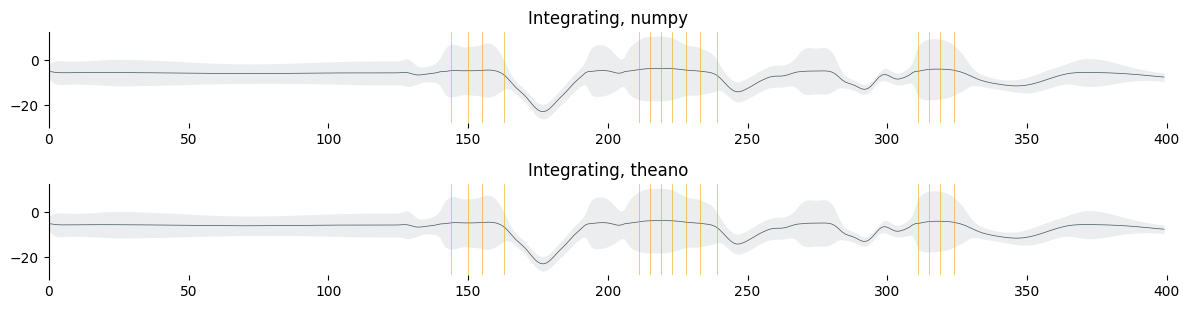

In [37]:
tic()
allLRni,allLVni,allM1ni,allM2ni = integrate_moments(stim,A,beta,C,
    dt          = dt,
    oversample  = oversample,
    maxrate     = maxrate,
    maxvcorr    = maxvcorr,
    method      = "second_order",
    int_method  = "euler")
toc()
subplot(411)
stderrplot(allLRni,allLVni,color=BLACK,lw=0.5)
niceaxis()
xlim(STARTSHOW,STOPSHOW)
title('Integrating, numpy')

tic()
allLRti,allLVti,allM1ti,allM2ti = integrate_moments_theano(Bh_train,p)
toc()
subplot(412)
stderrplot(allLRti,allLVti,color=BLACK,lw=0.5)
niceaxis()
xlim(STARTSHOW,STOPSHOW)
title('Integrating, theano')
tight_layout()

# "Deep" filtering in Numpy

t=3317ms 
dt=234ms 
nll, numpy 0.190627098648
t=277ms 
dt=1936ms 
nll, theano 0.18821614980697632


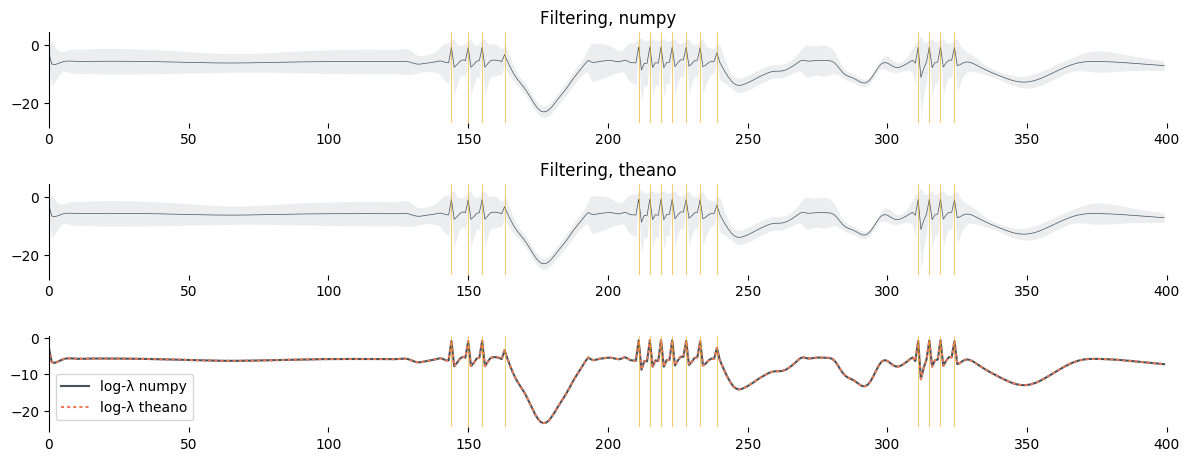

In [38]:
tic()
allLRn,allLVn,allM1n,allM2n,nlln,mrn,vrn = filter_moments(stim,Y_train,A,beta,C,p[0],
    dt          = dt,
    oversample  = oversample,
    maxrate     = maxrate,
    maxvcorr    = maxvcorr,
    method      = "second_order",
    int_method  = "euler",
    measurement = "moment",
    reg_cov     = reg_cov,
    reg_rate    = reg_rate,
    return_surrogates = True)
toc()
subplot(411)
stderrplot(allLRn,allLVn,color=BLACK,lw=0.5)
niceaxis()
xlim(STARTSHOW,STOPSHOW)
title('Filtering, numpy')
print('nll, numpy',nlln)

tic()
allLRt,allLVt,allM1t,allM2t,nllt,mrt,vrt = filter_moments_theano(Bh_train,Y_train,p)
priorLR,priorLV,priorM1,priorM2 = allLRt,allLVt,allM1t,allM2t
toc()
subplot(412)
stderrplot(allLRt,allLVt,color=BLACK,lw=0.5)
niceaxis()
xlim(STARTSHOW,STOPSHOW)
title('Filtering, theano')
print('nll, theano',nllt)
subplot(413)
plot(allLRn,color=BLACK,label='log-λ numpy')
plot(allLRt,':',color=RUST,label='log-λ theano')
niceaxis()
xlim(STARTSHOW,STOPSHOW)
tight_layout()

## CPU reference implenetation of depth-D parallel filtering

Demonstrate shallow depth-5 filtering. Even starting from a prior with no inforamation about the filtered state, these results can be relatively accurate. This could lead to parallel filtering routines to accelerate inference. 

On the CPU, parallel shallow filtering is slower than running the full forward pass, as we must perform O(D*N) work as opposed to O(N). However, this is a depth-D algorithm in theano that gives some improvement on the GPU.

In [39]:
from dstep import build_depth_shifted_priors_source

t=11532ms 
dt=1959ms 
Prior done
t=1960ms 
dt=174ms 
0.18821614980697632 0.190627098648 0.190207353052


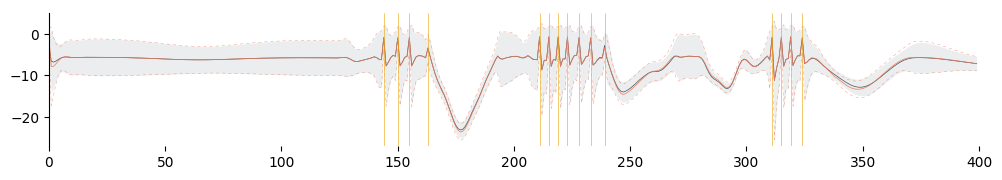

In [40]:
# Full filtering 
tic()
allLRt,allLVt,allM1t,allM2t,nllt,mrt,vrt = filter_moments_theano(Bh_train,Y_train,p)
toc()

# Prepare prior for "shallow" depth-D filtering
from dstep import filter_moments_dstep, build_depth_shifted_priors_source
D  = 15
iniM1,iniM2 = build_depth_shifted_priors_source(priorM1,priorM2,D)
print('Prior done')

# Depth D filtering (starting at true solution for initial conditions)
tic()
allLRnd,allLVnd,allM1nd,allM2nd,nllnd = filter_moments_dstep(D,stim,Y_train,A,beta,C,p[0],
    dt          = dt,
    oversample  = oversample,
    maxrate     = maxrate,
    maxvcorr    = maxvcorr,
    method      = "second_order",
    int_method  = "euler",
    measurement = "moment",
    reg_cov     = reg_cov,
    reg_rate    = reg_rate,
    prior       = (iniM1,iniM2))
toc()
subplot(311)
stderrplot(allLRt,allLVt,color=BLACK,lw=0.5)
stderrplot(allLRnd,allLVnd,color=RUST,lw=0.5,filled=0)
niceaxis()
ylim(max(ylim()[0],-100),5)
print(nllt,nlln,nllnd)

# Theano implementation

Separate functions are great for debugging, but let's clean things up a bit!

### Define constants

In [41]:
dt         = 1.0 # ms
oversample = 5
maxlogr    = 0.0
maxrate    = 1.0
dtfine     = dt/oversample
maxvcorr   = 10.0
reg_rate   = 0.0

In [42]:
TRC   = Tcon(array([np.eye(K)*reg_cov for i in range(N)]))
TAdt  = Tcon(A/oversample)
Tb    = Tcon(p.ravel()[1:K+1])
TC    = Tcon(C).dimshuffle('x',0,1)
TCC   = Tcon(C.dot(C.T)).dimshuffle('x',0,1)
mxl   = Tcon(maxlogr)
mxr   = Tcon(maxrate)
dtf   = Tcon(dtfine)
xvc   = Tcon(maxvcorr)
rr    = Tcon(reg_rate)
Tintr = Tcon(np.linspace(-4,4,25))

(M1, M2, depth)
(M1, M2, S, b)
(M1, M2, R0, RM, b)
(M1, M2, S, b)
(LM, LT, par)
(MQ, VQ, S, Y)
(LM, LT, MP, TP)
(M1, M2, MR, VR, LM, LV, Tb)
(M1, S, Y, LM, LV, MP, VP, b)
(M1, M2, S, Y, b, m)
(M1, M2, S, b)
(Tdi, M1, M2, S, Y, p)
(Xst, p)
(Xst, Y, p, M1, M2, depth)
t=12326ms 
dt=298ms 
0.18821614980697632 0.190627098648 0.18741697072982788


(-27.128285741806032, 5)

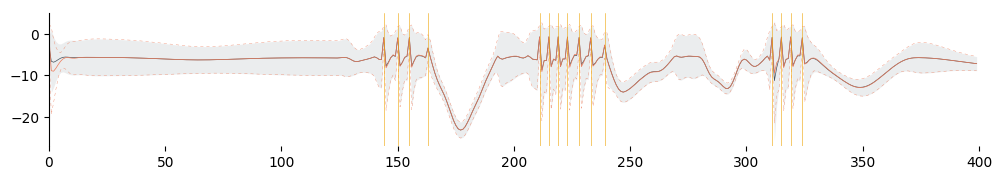

In [43]:
def theano_build_depth_shifted_priors_source(M1,M2,D):
    defaultM1 = Tcast(np.zeros((K,1)))
    defaultM2 = Tcast(np.eye(K)*1e-6)
    iniM1 = T.concatenate([T.repeat(T.shape_padleft(defaultM1),D,axis=0),M1[:-D]])
    iniM2 = T.concatenate([T.repeat(T.shape_padleft(defaultM2),D,axis=0),M2[:-D]])
    return iniM1,iniM2
theano_build_depth_shifted_priors =\
    Tquickfun(theano_build_depth_shifted_priors_source,
    T.tensor3("M1",dtype),
    T.tensor3("M2",dtype),
    T.scalar("depth",dtype='int32'))

def project_moments_parallel_theano_source(M1,M2,S,b):
    LV = M2.dot(b).dot(b) # N
    LM = M1[:,:,0].dot(b) # N
    LX = Tmn(mxl,LM+S) # N
    R0 = Tmn(mxr,Tsexp(LX))*dtf # N 
    RM = R0 * Tmn(1.0+0.5*LV,xvc) # N
    return LV,LM,LX,R0,RM
project_moments_parallel_theano =\
    Tquickfun(project_moments_parallel_theano_source,
    T.tensor3("M1",dtype),
    T.tensor3("M2",dtype),
    T.vector("S",dtype),
    T.vector("b",dtype))

def euler_update_moments_parallel_theano_source(M1,M2,R0,RM,b):
    M1  += TAdt.dot(M1).transpose(1,0,2)
    CB   = TC.dot(b.dimshuffle('x',0))
    J    = CB*R0[:,None,None]+TAdt[None,:,:]
    JM2  = T.batched_dot(J,M2)
    M2  += JM2 + JM2.transpose((0,2,1))
    M1  += TC *RM[:,None,None]
    M2  += TCC*RM[:,None,None]
    return M1,M2
euler_update_moments_parallel_theano =\
    Tquickfun(euler_update_moments_parallel_theano_source,
    T.tensor3("M1",dtype),
    T.tensor3("M2",dtype),
    T.vector("R0",dtype),
    T.vector("RM",dtype),
    T.vector("b",dtype))

def integrate_moments_parallel_theano_source(M1,M2,S,b):
    _,_ ,_,R0,RM = project_moments_parallel_theano_source(M1,M2,S,b)
    M1,M2 = euler_update_moments_parallel_theano_source(M1,M2,R0,RM,b)
    return M1,M2
integrate_moments_parallel_theano =\
    Tquickfun(integrate_moments_parallel_theano_source,
    T.tensor3("M1",dtype),
    T.tensor3("M2",dtype),
    T.vector("S",dtype),
    T.vector("b",dtype))

def univariate_prior_parallel_theano_source(LM,LT,m):
    TQ = LT + rr
    VQ = Tsinv(TQ)
    MQ = (LM*LT+m*rr)*VQ
    return MQ,VQ
univariate_prior_parallel_theano =\
    Tquickfun(univariate_prior_parallel_theano_source,
    T.vector("LM",dtype),
    T.vector("LT",dtype),
    T.vector("par",dtype))

def quadrature_moments_parallel_theano_source(MQ,VQ,S,Y):
    X  = Tintr[None,:]*T.sqrt(VQ)[:,None]+MQ[:,None]
    R0 = X + S[:,None]+Tslog(Tcast(dt))
    L  = Y[:,None]*R0-Tsexp(R0)
    L  = L - T.max(L,axis=1)[:,None]
    L += -0.5*((Tintr**2.0)[None,:]+Tslog(VQ)[:,None])
    PR = Tmx(Tcon(1e-7),Tsexp(L))
    NR = Tsinv(T.sum(PR,axis=1))
    MP = T.sum(X*PR,axis=1)*NR
    VP = T.sum((X-MP[:,None])**2.0*PR,axis=1)*NR
    return MP,VP
quadrature_moments_parallel_theano =\
    Tquickfun(quadrature_moments_parallel_theano_source,
    T.vector("MQ",dtype),
    T.vector("VQ",dtype),
    T.vector("S",dtype),
    T.vector("Y",dtype))

def surrogate_likelihood_parallel_theano_source(LM,LT,MP,TP):
    VR = Tsinv(TP-LT)
    MR = (MP*TP-LM*LT)*VR
    return MR,VR
surrogate_likelihood_parallel_theano =\
    Tquickfun(surrogate_likelihood_parallel_theano_source,
    T.vector("LM",dtype),
    T.vector("LT",dtype),
    T.vector("MP",dtype),
    T.vector("TP",dtype))

def conditional_gaussian_parallel_theano_source(M1,M2,MR,VR,LM,LV,Tb):
    M2B = M2.dot(Tb.dimshuffle(0,'x')) # NxKx1
    KG  = M2B/(VR+LV)[:,None,None] #NxKx1
    M2 -= T.batched_dot(KG,M2B.transpose(0,2,1))
    M1 += KG*(MR-LM)[:,None,None]
    return M1,M2
conditional_gaussian_parallel_theano =\
    Tquickfun(conditional_gaussian_parallel_theano_source,
    T.tensor3("M1",dtype),
    T.tensor3("M2",dtype),
    T.vector("MR",dtype),
    T.vector("VR",dtype),
    T.vector("LM",dtype),
    T.vector("LV",dtype),
    T.vector("Tb",dtype))

def loglikelihood_parallel_theano_source(M1,S,Y,LM,LV,MP,VP,b):
    LgM  = M1[:,:,0].dot(b) # N
    LgR  = Tmn(mxl,LgM+S) # N
    LgYX = Y*LgR-Tsexp(LgR)
    LgL  = LgYX - 0.5*(Tslog(LV/VP) + (MP-LM)**2.0/LV)
    return LgL
loglikelihood_parallel_theano = Tquickfun(loglikelihood_parallel_theano_source,
    T.tensor3("M1",dtype),
    T.vector("S",dtype),
    T.vector("Y",dtype),
    T.vector("LM",dtype),
    T.vector("LV",dtype),
    T.vector("MP",dtype),
    T.vector("VP",dtype),
    T.vector("b",dtype))

def measurement_update_parallel_theano_source(M1,M2,S,Y,b,m):
    LV,LM,_,_,_ = project_moments_parallel_theano_source(M1,M2,S,b)
    LT    = Tsinv(LV)
    MQ,VQ = univariate_prior_parallel_theano_source(LM,LT,m)
    MP,VP = quadrature_moments_parallel_theano_source(MQ,VQ,S,Y)
    TP    = Tsinv(VP)
    MR,VR = surrogate_likelihood_parallel_theano_source(LM,LT,MP,TP)
    M1,M2 = conditional_gaussian_parallel_theano_source(M1,M2,MR,VR,LM,LV,b)
    LL    = loglikelihood_parallel_theano_source(M1,S,Y,LM,LV,MP,VP,b)
    return M1,M2,LL
measurement_update_parallel_theano = Tquickfun(measurement_update_parallel_theano_source,
    T.tensor3("M1",dtype),
    T.tensor3("M2",dtype),
    T.vector("S",dtype),
    T.vector("Y",dtype),
    T.vector("b",dtype),
    T.scalar("m",dtype))

def integrate_dt_parallel_theano_source(M1,M2,S,b):
    for k in range(oversample):
        M1,M2 = integrate_moments_parallel_theano_source(M1,M2,S,b)
    return M1,M2
integrate_dt_parallel_theano = Tquickfun(integrate_dt_parallel_theano_source,
    T.tensor3("M1",dtype),
    T.tensor3("M2",dtype),
    T.vector("S",dtype),
    T.vector("b",dtype))

def filter_moments_parallel_theano_source(di,M1,M2,S,Y,p):
    if reg_cov>0.0:
        M2 = 0.5*(M2 + M2.transpose(0,2,1)) + TRC
    offsets = T.maximum(0,T.arange(N)+di)
    offsets = T.cast(offsets,'int32')
    S = S[offsets]
    Y = Y[offsets]
    b = p[1:K+1]
    m = p[0]
    M1,M2    = integrate_dt_parallel_theano_source(M1,M2,S,b)
    M1,M2,LL = measurement_update_parallel_theano_source(M1,M2,S,Y,b,m)
    return M1,M2,LL
filter_moments_parallel_theano = Tquickfun(filter_moments_parallel_theano_source,
    T.scalar("Tdi",dtype),
    T.tensor3("M1",dtype),
    T.tensor3("M2",dtype),
    T.vector("S",dtype),
    T.vector("Y",dtype),
    T.vector("p",dtype))

def project_stimulus_theano_source(Xst,p):
    m   = p[0]
    b   = p[1:K+1]
    bst = p[K+1:]
    return Xst.dot(bst) + m
project_stimulus_theano = Tquickfun(project_stimulus_theano_source,
    T.matrix("Xst",dtype),
    T.vector("p",dtype))

def scan_moments_parallel_theano_parameters_source(Xst,Y,p,M1,M2,depth):
    M1,M2 = theano_build_depth_shifted_priors_source(M1,M2,depth)
    S = project_stimulus_theano_source(Xst,p)
    [M1,M2,LL], up = theano.scan(filter_moments_parallel_theano_source,
                                    sequences     = [T.arange(1-depth,1)],
                                    outputs_info  = [M1,M2,None],
                                    non_sequences = [S,Y,p])
    M1,M2 = M1[-1],M2[-1]
    LV,_,LR,_,_ = project_moments_parallel_theano_source(M1,M2,S,p[1:1+K])
    NLL = -T.mean(LL[-1])
    return LR,LV,M1,M2,NLL
scan_moments_parallel_theano_parameters = Tquickfun(scan_moments_parallel_theano_parameters_source,
    T.matrix("Xst",dtype),
    T.vector("Y",dtype),
    T.vector("p",dtype),
    T.tensor3("M1",dtype),
    T.tensor3("M2",dtype),
    T.scalar("depth",dtype='int32'))
                                                    

tic()
allLR,allLV,allM1,allM2,NLL = scan_moments_parallel_theano_parameters(Bh_train,Y_train,p,allM1t,allM2t,D)
toc()
subplot(311)
stderrplot(allLRt,allLVt,color=BLACK,lw=0.5)
stderrplot(allLR,allLV,color=RUST,lw=0.5,filled=0)
niceaxis()
print(nllt,nlln,NLL)
ylim(max(ylim()[0],-100),5) 

## Theano implementation, one function

(Xst, Y, p, M1, M2, depth)
t=3017ms 
dt=327ms 


(-27.128285741806032, 5)

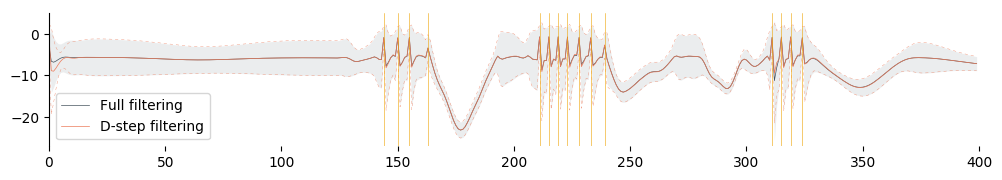

In [44]:
def project_moments_parallel_theano_source(M1,M2,S,b):
    LgV = M2.dot(b).dot(b) # N
    LgM = M1[:,:,0].dot(b) # N
    LgX = Tmn(mxl,LgM+S) # N
    R0 = Tmn(mxr,Tsexp(LgX))*dtf # N 
    RM = R0 * Tmn(1.0+0.5*LgV,xvc) # N
    return LgV,LgM,LgX,R0,RM
    
def integrate_moments_parallel_theano_source(M1,M2,S,b):
    LGV = M2.dot(b).dot(b) # N
    LGM = M1[:,:,0].dot(b)  # N
    LGX = Tmn(mxl,LGM+S) # N
    R0   = Tmn(mxr,Tsexp(LGX))*dtf # N 
    RM   = R0 * Tmn(1.0+0.5*LGV,xvc) # N
    CB   = TC.dot(b.dimshuffle('x',0))
    J    = CB*R0[:,None,None]+TAdt[None,:,:]
    JM2  = T.batched_dot(J,M2)
    M2  += JM2 + JM2.transpose(0,2,1)    + TCC*RM[:,None,None]
    M1  += TAdt.dot(M1).transpose(1,0,2) + TC *RM[:,None,None]
    return M1,M2

def measurement_update_parallel_theano_source(M1,M2,S,Y,b,m):
    LV = M2.dot(b).dot(b)
    LM = M1[:,:,0].dot(b)
    LT = Tsinv(LV)
    TQ = LT + rr
    VQ = Tsinv(TQ)
    MQ = (LM*LT+m*rr)*VQ
    X  = Tintr[None,:]*T.sqrt(VQ)[:,None]+MQ[:,None]
    R0 = X + S[:,None]+Tslog(dt)
    L  = Y[:,None]*R0-Tsexp(R0)
    L  = L - T.max(L,axis=1)[:,None]
    L += -0.5*((Tintr**2.0)[None,:]+Tslog(VQ)[:,None])
    PR = Tmx(1e-7,Tsexp(L))
    NR = Tsinv(T.sum(PR,axis=1))
    MP = T.sum(X*PR,axis=1)*NR
    VP = T.sum((X-MP[:,None])**2*PR,axis=1)*NR
    TP = Tsinv(VP)
    VR = Tsinv(TP-LT)
    MR = (MP*TP-LM*LT)*VR
    # Multivariate conditional update
    M2B = M2.dot(b.dimshuffle(0,'x')) # NxKx1
    KG  = M2B/(VR+LV)[:,None,None] #NxKx1
    M2 -= T.batched_dot(KG,M2B.transpose(0,2,1))
    M1 += KG*(MR-LM)[:,None,None]
    LR  = Tmn(mxl,M1[:,:,0].dot(b)+S) # N
    LYX = Y*LR-Tsexp(LR)
    LL  = LYX - 0.5*(Tslog(LV/VP) + (MP-LM)**2.0/LV)
    NLL = -T.mean(LL)
    return M1,M2,NLL

def filter_moments_parallel_theano_source(di,M1,M2,S,Y,b,m):
    if reg_cov>0:
        M2 = 0.5*(M2 + M2.transpose(0,2,1)) + TRC
    offsets = T.maximum(0,T.arange(N)+di)
    offsets = T.cast(offsets,'int32')
    S = S[offsets]
    Y = Y[offsets]
    for k in range(oversample):
        M1,M2 = integrate_moments_parallel_theano_source(M1,M2,S,b)
    M1,M2,NLL = measurement_update_parallel_theano_source(M1,M2,S,Y,b,m)
    return M1,M2,NLL

def scan_moments_parallel_theano_parameters_source(Xst,Y,p,M1,M2,depth):
    b = p[1:K+1]
    mm = p[0]    
    M1,M2 = theano_build_depth_shifted_priors_source(M1,M2,depth)
    S = project_stimulus_theano_source(Xst,p)
    [M1,M2,LL], up = theano.scan(filter_moments_parallel_theano_source,
                                    sequences     = [T.arange(1-depth,1)],
                                    outputs_info  = [M1,M2,None],
                                    non_sequences = [S,Y,b,mm])
    M1,M2 = M1[-1],M2[-1]
    LgV = M2.dot(b).dot(b)
    LgR = Tmn(mxl,M1[:,:,0].dot(b)+S)
    NLL = -T.mean(LL[-1])
    return LgR,LgV,M1,M2,NLL

scan_moments_parallel_theano_parameters = Tquickfun(scan_moments_parallel_theano_parameters_source,
    T.matrix("Xst",dtype),
    T.vector("Y",dtype),
    T.vector("p",dtype),
    T.tensor3("M1",dtype),
    T.tensor3("M2",dtype),
    T.scalar("depth",dtype='int32'))
    
tic()
allLR,allLV,allM1,allM2,NLL = scan_moments_parallel_theano_parameters(Bh_train,Y_train,p,allM1t,allM2t,D)
toc()
subplot(311)
stderrplot(allLRt,allLVt,color=BLACK,lw=0.5,label='Full filtering')
stderrplot(allLR,allLV,color=RUST,lw=0.5,filled=0,label='D-step filtering')
niceaxis()
ylim(max(ylim()[0],-100),5) 

# Add support for surrogate measurements

In [45]:
def measurement_update_parallel_theano_surrogate_source(M1,M2,S,Y,MR,VR,b):
    LV  = M2.dot(b).dot(b) # N
    LM  = Tcast(M1[:,:,0].dot(b)) # N
    LT  = Tsinv(LV)
    # Multivariate conditional update
    M2B = M2.dot(b.dimshuffle(0,'x'))
    KG  = Tsdiv(M2B,(VR+LV)[:,None,None])
    M2 -= T.batched_dot(KG,M2B.transpose(0,2,1))
    M1 += KG*(MR-LM)[:,None,None]
    # Compute univariate update for likelihood
    TR  = Tsinv(VR)
    TP  = LT + TR
    VP  = Tsinv(TP)
    MP  = (LT*LM+TR*MR)*VP
    # Compute likelihood
    LR  = Tmn(mxl,M1[:,:,0].dot(b)+S)
    LYX = Y*LR-Tsexp(LR)
    LL  = LYX - 0.5*(Tslog(LV/VP) + (MP-LM)**2.0/LV)
    kill = T.isnan(LL)|T.isinf(LL)
    LL = T.switch(kill,-1000,LL)
    return M1,M2,-T.mean(LL)

def filter_moments_parallel_theano_surrogate_source(di,M1,M2,S,Y,MR,VR,b):
    if reg_cov>0:
        M2 = 0.5*(M2 + M2.transpose(0,2,1)) + TRC
    offsets = T.maximum(0.0,T.arange(N)+di)
    offsets = T.cast(offsets,'int32')
    S  = S[offsets]
    Y  = Y[offsets]
    MR = MR[offsets]
    VR = VR[offsets]
    for k in range(oversample):
        M1,M2 = integrate_moments_parallel_theano_source(M1,M2,S,b)
    M1,M2,NLL = measurement_update_parallel_theano_surrogate_source(M1,M2,S,Y,MR,VR,b)
    return M1,M2,NLL

def scan_moments_parallel_theano_surrogate_source(X,Y,p,M1,M2,MR,VR,depth):
    b     = p[1:K+1]
    m     = p[0]    
    bx    = p[K+1:]
    M1,M2 = theano_build_depth_shifted_priors_source(M1,M2,depth)
    S     = X.dot(bx) + m
    [M1,M2,NLL], up = theano.scan(filter_moments_parallel_theano_surrogate_source,
                                    sequences     = [T.arange(1-depth,1)],
                                    outputs_info  = [M1,M2,None],
                                    non_sequences = [S,Y,MR,VR,b])
    M1,M2 = M1[-1],M2[-1]
    LgV   = Tmx(Tcast(1e-12),M2.dot(b).dot(b))
    LgR   = Tmn(mxl,M1[:,:,0].dot(b)+S)
    return LgR,LgV,M1,M2,NLL[-1]

scan_moments_parallel_theano_surrogate = Tquickfun(scan_moments_parallel_theano_surrogate_source,
    T.matrix("X",dtype),
    T.vector("Y",dtype),
    T.vector("p",dtype),
    T.tensor3("M1",dtype),
    T.tensor3("M2",dtype),
    T.vector("MR",dtype),
    T.vector("VR",dtype),
    T.scalar("depth",dtype='int32'))

print('Theano shallow filter using surrogate measurements defined')

(X, Y, p, M1, M2, MR, VR, depth)
Theano shallow filter using surrogate measurements defined


## Test theano implementation with surrogate measurements

t=11773ms 
dt=44ms 
0.18821614980697632 0.190627098648 0.18970857560634613


(-27.277731633186342, 5)

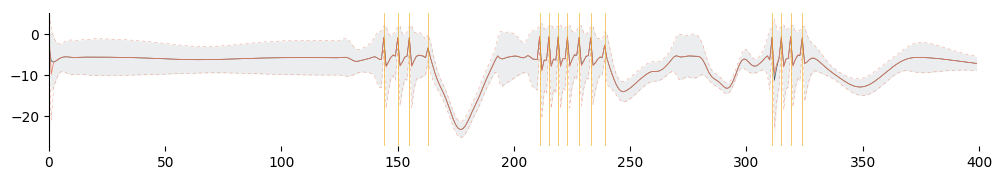

In [46]:
# Get surrogate measurements
allLRt,allLVt,allM1t,allM2t,nllt,mrt,vrt = filter_moments_theano(Bh_train,Y_train,p)
tic()
allLR,allLV,M1,M2,NLL = scan_moments_parallel_theano_surrogate(Bh_train,Y_train,p,priorM1,priorM2,mrt,vrt,3)
toc()
subplot(311)
stderrplot(allLRt,allLVt,color=BLACK,lw=0.5)
stderrplot(allLR,allLV,color=RUST,lw=0.5,filled=0)
niceaxis()
print(nllt,nlln,NLL)
ylim(max(ylim()[0],-100),5) 

# Benchmark

In [59]:
# Integrate moments with numpy
tic(disp=False)
allLRni,allLVni,allM1ni,allM2ni = integrate_moments(stim,A,beta,C,
    dt          = dt,
    oversample  = oversample,
    maxrate     = maxrate,
    maxvcorr    = maxvcorr,
    method      = "second_order",
    int_method  = "euler")
inp = toc(disp=False)

# integrate moments with theano
tic(disp=False)
allLRti,allLVti,allM1ti,allM2ti = integrate_moments_theano(Bh_train,p)
ith = toc(disp=False)

# filter moments with numpy
tic(disp=False)
allLRn,allLVn,allM1n,allM2n,nlln,mrn,vrn = filter_moments(stim,Y_train,A,beta,C,p[0],
    dt          = dt,
    oversample  = oversample,
    maxrate     = maxrate,
    maxvcorr    = maxvcorr,
    method      = "second_order",
    int_method  = "euler",
    measurement = "moment",
    reg_cov     = reg_cov,
    reg_rate    = reg_rate,
    return_surrogates = True)
fnp = toc(disp=False)

# filter moments with theano
tic(disp=False)
allLRt,allLVt,allM1t,allM2t,nllt,mrt,vrt = filter_moments_theano(Bh_train,Y_train,p)
fth = toc(disp=False)

# surrogate filtering theano
tic(disp=False)
allLRt,allLVt,allM1t,allM2t,nllt= filter_surrogate_theano(Bh_train,Y_train,p,mrt,vrt)
fss = toc(disp=False)

# depth-d filtering numpy
D  = 15
tic(disp=False)
allLRnd,allLVnd,allM1nd,allM2nd,nllnd = filter_moments_dstep(D,stim,Y_train,A,beta,C,p[0],
    dt          = dt,
    oversample  = oversample,
    maxrate     = maxrate,
    maxvcorr    = maxvcorr,
    method      = "second_order",
    int_method  = "euler",
    measurement = "moment",
    reg_cov     = reg_cov,
    reg_rate    = reg_rate,
    prior       = build_depth_shifted_priors_source(priorM1,priorM2,D))
dnp = toc(disp=False)

# depth-d filtering, Theano
tic(disp=False)
allLR,allLV,allM1,allM2,NLL = scan_moments_parallel_theano_parameters(Bh_train,Y_train,p,allM1t,allM2t,D)
dth = toc(disp=False)

# depth-d filtering with surrogates, Theano
tic(disp=False)
allLR,allLV,M1,M2,NLL = scan_moments_parallel_theano_surrogate(Bh_train,Y_train,p,priorM1,priorM2,mrt,vrt,3)
toc(disp=False)

print('Numpy  moment    integration',inp)
print('Theano moment    integration',ith)
print('Numpy  moment    filtering  ',fnp)
print('Theano moment    filtering  ',fth)
print('Theano surrogate filtering  ',fss)
print('Numpy  depth-D   filtering  ',dnp)
print('Theano depth-D   filtering  ',dth)
print('Theano depth-D   surrogate  ',dth)


Numpy  moment    integration 95
Theano moment    integration 748
Numpy  moment    filtering   148
Theano moment    filtering   1295
Theano surrogate filtering   1000
Numpy  depth-D   filtering   95
Theano depth-D   filtering   199


# Compute gradients

Gradients aren't really accurate at float32 precision

In [ ]:
'''theano_shallow_gradient = Tfun(inp = [Xst,TY_,MR_,VR_,par], 
          out = [Tcast(theano.gradient.jacobian(Tcast(_LLpar[-1]),Tcast(par)))])

large   = sqrt(np.finfo('float32').max)

def objective(p):
    allLR,allLV,M1,M2,NLL = scan_moments_parallel_theano_surrogate(Bh_train,Y,mrt,vrt,p)
    if not isfinite(NLL):
        NLL = large
    return NLL

def gradient(p):
    g = theano_shallow_gradient(Bh_train,Y,mrt,vrt,p)[0]
    return g

g1 = numeric_grad(objective,p,1e-4)
g2 = gradient(p)
print(v2str(g1))
print(v2str(g2))
'''

# Optimize

In [23]:
result = p.copy()

#result = array([-4.47485402448,-6.72860060925,-10.6006414101,16.3551035615,-17.4139653139,19.8456123891,-8.87941524903,-0.53968146647,0.40470884356,0.0081113061503,0.147167177181,0.730789289648,-0.232357798704,0.143245700568,-0.325816468342,0.304508845892,-0.195850447753])
#result = array([-4.47881142922,-6.70467154546,-10.5773170227,16.3240680777,-17.4528938311,20.7620487554,-8.89687340784,-0.539562988035,0.404100055749,0.00812310614368,0.147457216399,0.732992182046,-0.231737112458,0.143636583881,-0.326526473195,0.304531168294,-0.195385352144]])

In [ ]:
large = np.sqrt(np.finfo('float32').max)

nfeval = 0
x0     = p.copy
best   = large

sys.stdout.write('\n')
last_shown = current_milli_time()

def progress_update():
    global best, x0, nfeval, last_shown
    if current_milli_time() - last_shown > 500:
        ss = np.float128(best).astype(str)
        ss += ' '*(20-len(ss))
        out = '\rNo. function evals %6d \tBest value %s'%(nfeval,ss)
        sys.stdout.write(out)
        sys.stdout.flush()
        last_shown = current_milli_time()

def objective(p):
    global mrt,vrt,allM1t,allM2t,  best, x0, nfeval
    allLR,allLV,M1,M2,NLL = scan_moments_parallel_theano_surrogate(Bh_train,Y_train,p,allM1t,allM2t,mrt,vrt,15)
    if not isfinite(NLL):
        NLL = large
    if NLL<best:
        best = NLL
        x0   = p
    nfeval += 1
    progress_update()
    return NLL 

for i in range(100):
    # Get surrogate measurements and states for prior
    allLRt,allLVt,allM1t,allM2t,nllt,mrt,vrt = filter_moments_theano(Bh_train,Y_train,result)
    # optimize
    x = scipy.optimize.minimize(objective,result,method='Nelder-Mead',options={'maxiter':100,'maxfev':100})
    #
    progress_update()
    sys.stdout.write('\n')
    sys.stdout.flush()
    #
    print(x.success)
    print(x.message)
    result = x.x
    print(v2str_long(result))


    tic()
    allLR,allLV,allM1,allM2,NLL = scan_moments_parallel_theano_parameters(Bh_train,Y_train,result,allM1t,allM2t,15)
    toc()
    subplot(311)
    stderrplot(allLR,allLV,color=BLACK,lw=1,label='MC Filtering')
    plot(project_stimulus_theano(Bh_train,result) + By_train.dot(result[1:K+1]),color=RUST,lw=1,label='GLM log-λ')
    niceaxis()
    ylim(max(ylim()[0],-100),5) 
    xlabel('Time (ms)')
    ylabel('$\ln(\lambda)$')

    subplot(312)
    logm,logv,expm,expv = ensemble_sample_moments(Bh_train.dot(result[K+1:])+result[0],B,result[1:K+1],M=100)
    stderrplot(logm,logv,color=AZURE,filled=0,lw=1,label='point process monte carlo')
    allLRt,allLVt,allM1t,allM2t = integrate_moments_theano(Bh_train,result)
    stderrplot(allLRt,allLVt,color=OCHRE,filled=0,lw=1,label='Moment Equations')
    niceaxis()
    ylim(max(ylim()[0],-100),5) 
    xlabel('Time (ms)')
    ylabel('$\ln(\lambda)$')
    show()
    
    # reset this
    best   = large

In [ ]:
large = np.sqrt(np.finfo('float32').max)

# Get surrogate measurements and states for prior
allLRt,allLVt,allM1t,allM2t,nllt,mrt,vrt = filter_moments_theano(Bh_train,Y_train,result)
allLRt,allLVt,allM1t,allM2t = integrate_moments_theano(Bh_train,result)

verbose = 1

def objective(p):
    global mrt,vrt,iteration
    allLR,allLV,M1,M2,NLL = scan_moments_parallel_theano_surrogate(Bh_train,Y_train,mrt,vrt,p,allM1t,allM2t,15)
    if not isfinite(NLL):
        NLL = large
    return NLL

try:
    result = minimize_retry(objective,result,jac=False,verbose=verbose,simplex_only=True)
    print("Finished optimization")
except KeyboardInterrupt:
    print('Optimization paused')
    
print('x=','['+','.join([np.float128(x).astype(str) for x in result])+']')
print("Total absolute change from GLM fit is",sum(abs(result-p0)))

tic()
allLR,allLV,allM1,allM2,NLL = scan_moments_parallel_theano_parameters(Bh_train,Y_train,result)
toc()
subplot(311)
stderrplot(allLR,allLV,color=BLACK,lw=1,label='MC Filtering')
plot(project_stimulus_theano(Bh_train,result) + By_train.dot(result[1:K+1]),color=RUST,lw=1,label='GLM log-λ')
niceaxis()
ylim(max(ylim()[0],-100),5) 
xlabel('Time (ms)')
ylabel('$\ln(\lambda)$')

subplot(312)
logm,logv,expm,expv = ensemble_sample_moments(Bh_train.dot(result[K+1:])+result[0],B,result[1:K+1],M=100)
stderrplot(logm,logv,color=AZURE,filled=0,lw=1,label='point process monte carlo')
allLRt,allLVt,allM1t,allM2t = integrate_moments_theano(Bh_train,result)
stderrplot(allLRt,allLVt,color=OCHRE,filled=0,lw=1,label='Moment Equations')
niceaxis()
ylim(max(ylim()[0],-100),5) 
xlabel('Time (ms)')
ylabel('$\ln(\lambda)$')
#savefigure('MCARPPGLM_filtering')

In [ ]:
plot(result[1:K+1].dot(B),color=AZURE)
plot(result[K+1:].dot(B),color=RUST)
axhline(color='k',lw=1)
simpleraxis()
positivex()

In [ ]:
logm,logv,expm,expv = ensemble_sample_moments(Bh_train.dot(result[K+1:])+result[0],B,result[1:K+1],M=100)

ll = Y_train*logm-sexp(logm)*(1+0.5*logv)
NLLPP = -mean(ll)
print(NLLPP)

In [ ]:
tic()
allLR,allLV,allM1,allM2,NLL = scan_moments_parallel_theano_parameters(Bh_train,Y_train,result)
toc()
subplot(311)
stderrplot(allLR,allLV,color=BLACK,lw=1,label='MC Filtering')
plot(project_stimulus_theano(Bh_train,result) + By_train.dot(result[1:K+1]),color=RUST,lw=1,label='GLM log-λ')

logm,logv,expm,expv = ensemble_sample_moments(Bh_train.dot(result[K+1:])+result[0],B,result[1:K+1],M=1000)
stderrplot(logm,logv,color=AZURE,filled=0,lw=1,label='point process monte carlo')
niceaxis()
ylim(max(ylim()[0],-100),5) 
xlabel('Time (ms)')
ylabel('$\ln(\lambda)$')
#savefigure('MCARPPGLM_filtering')